In [1]:
import tensorflow as tf
import os
import cv2
import imghdr

In [2]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!chmod 600 /content/kaggle.json

In [3]:
!kaggle datasets download -d carlosrunner/pizza-not-pizza -p /content/

pizza-not-pizza.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
import zipfile

In [5]:
with zipfile.ZipFile('/content/pizza-not-pizza.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/pizza-not-pizza')

In [6]:
data_dir = '/content/pizza-not-pizza/pizza_not_pizza'

In [7]:
files = os.listdir(data_dir)
print(files)

['food101_subset.py', 'not_pizza', 'pizza']


In [8]:
os.remove("/content/pizza-not-pizza/pizza_not_pizza/food101_subset.py")

In [9]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))

In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory(data_dir)

Found 1966 files belonging to 2 classes.


In [13]:
class_names = data.class_names
print(class_names)

['not_pizza', 'pizza']


In [14]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [15]:
batch[0].shape

(32, 256, 256, 3)

In [16]:
batch[1]

array([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

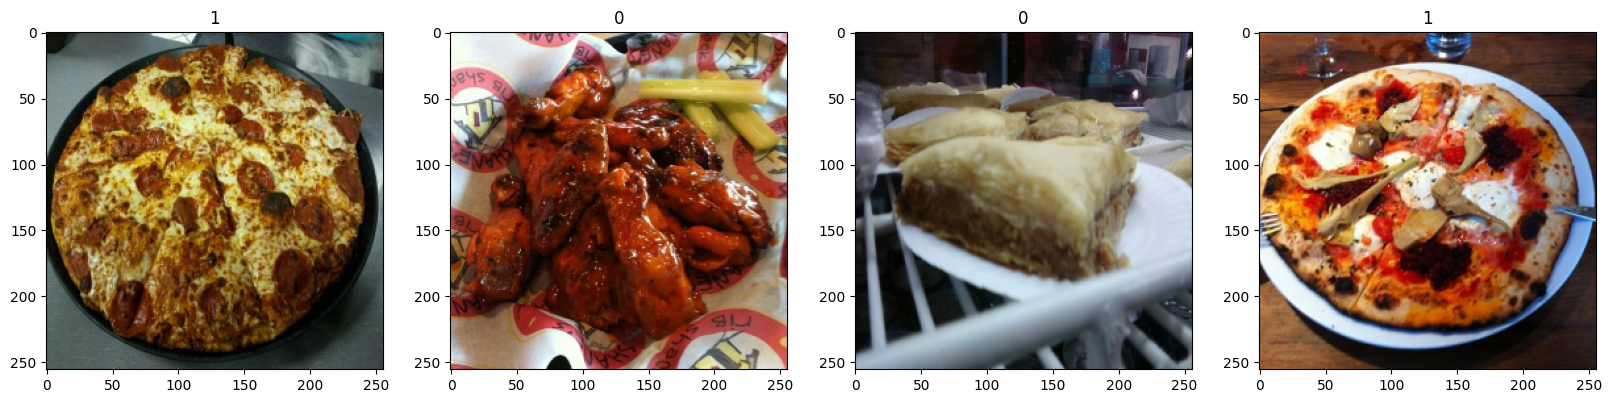

In [17]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Pizza ----> 1  
# Not Pizza ----> 0

In [18]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[1.99019611e-01, 1.20588236e-01, 1.06862746e-01],
          [2.23529413e-01, 1.19607843e-01, 1.14705883e-01],
          [2.26470590e-01, 1.02941178e-01, 1.05882354e-01],
          ...,
          [6.27451017e-02, 3.62745114e-02, 1.56862754e-02],
          [6.66666701e-02, 5.19607849e-02, 4.01960798e-02],
          [8.62745121e-02, 7.84313753e-02, 8.33333358e-02]],
 
         [[2.07843140e-01, 1.22549020e-01, 1.03921570e-01],
          [2.33333334e-01, 1.24509804e-01, 1.12745099e-01],
          [2.55882353e-01, 1.24509804e-01, 1.28431380e-01],
          ...,
          [7.84313753e-02, 3.92156877e-02, 3.23529430e-02],
          [7.25490227e-02, 3.52941193e-02, 2.64705885e-02],
          [1.14705883e-01, 7.64705911e-02, 7.15686306e-02]],
 
         [[2.03921571e-01, 1.08823530e-01, 9.31372568e-02],
          [2.46078432e-01, 1.29411772e-01, 1.20588236e-01],
          [2.49019608e-01, 1.13725491e-01, 1.18627451e-01],
          ...,
          [7.45098069e-02, 3.43137272e-02, 3.9215

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1) + 1

In [21]:
len(data)

62

In [22]:
train_size + val_size + test_size

62

In [23]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [25]:
model = Sequential()

In [26]:
model.add(Conv2D(128, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

In [29]:
logdir='/content/logs'

In [30]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
43/43 [==============================] - 18s 218ms/step - loss: 0.6919 - accuracy: 0.5422 - val_loss: 0.6675 - val_accuracy: 0.5781
Epoch 2/20
43/43 [==============================] - 9s 208ms/step - loss: 0.6753 - accuracy: 0.5596 - val_loss: 0.6453 - val_accuracy: 0.6510
Epoch 3/20
43/43 [==============================] - 11s 235ms/step - loss: 0.6511 - accuracy: 0.6265 - val_loss: 0.6027 - val_accuracy: 0.6719
Epoch 4/20
43/43 [==============================] - 10s 213ms/step - loss: 0.5769 - accuracy: 0.7115 - val_loss: 0.5037 - val_accuracy: 0.7656
Epoch 5/20
43/43 [==============================] - 10s 234ms/step - loss: 0.5388 - accuracy: 0.7384 - val_loss: 0.4820 - val_accuracy: 0.7734
Epoch 6/20
43/43 [==============================] - 11s 247ms/step - loss: 0.4623 - accuracy: 0.7943 - val_loss: 0.4705 - val_accuracy: 0.7786
Epoch 7/20
43/43 [==============================] - 10s 221ms/step - loss: 0.4580 - accuracy: 0.7892 - val_loss: 0.4865 - val_accuracy: 0.7891


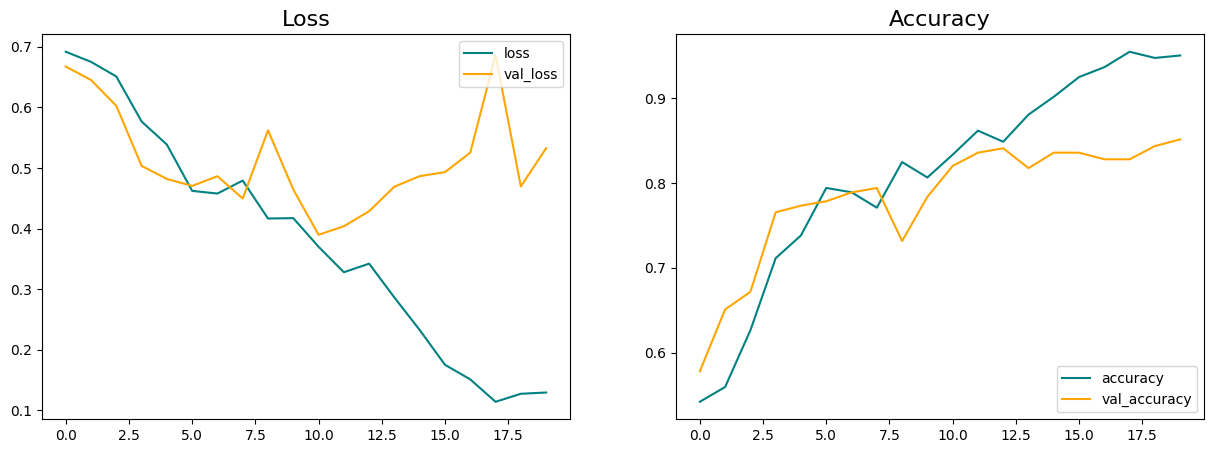

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot Loss
axs[0].plot(hist.history['loss'], color='teal', label='loss')
axs[0].plot(hist.history['val_loss'], color='orange', label='val_loss')
axs[0].set_title('Loss', fontsize=16)
axs[0].legend(loc="upper right")

# Plot Accuracy
axs[1].plot(hist.history['accuracy'], color='teal', label='accuracy')
axs[1].plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
axs[1].set_title('Accuracy', fontsize=16)
axs[1].legend(loc="lower right")

plt.show()

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 1s 718ms/step


In [36]:
print("Precision: {:.4f}, Recall: {:.4f}, Accuracy: {:.4f}".format(pre.result(), re.result(), acc.result()))

Precision: 0.7632, Recall: 0.8614, Accuracy: 0.8010


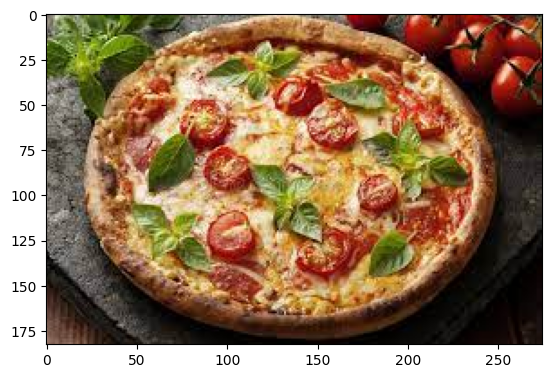

In [37]:
img_bgr1 = cv2.imread('/content/testpizza.jpeg')
img_rgb1 = cv2.cvtColor(img_bgr1, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb1)
plt.show()

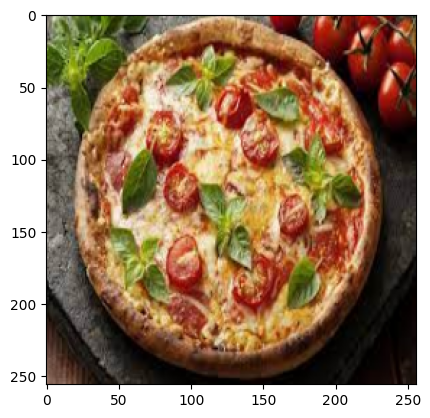

In [38]:
resize1 = tf.image.resize(img_rgb1, (256,256))
plt.imshow(resize1.numpy().astype(int))
plt.show()

In [39]:
yhat1 = model.predict(np.expand_dims(resize1/255, 0))

1/1 [==============================] - 0s 148ms/step


In [40]:
yhat1

array([[0.99208003]], dtype=float32)

In [41]:
if yhat1 > 0.5: 
    print(f'Predicted class is Pizza')
else:
    print(f'Predicted class is NOT Pizza')

Predicted class is Pizza


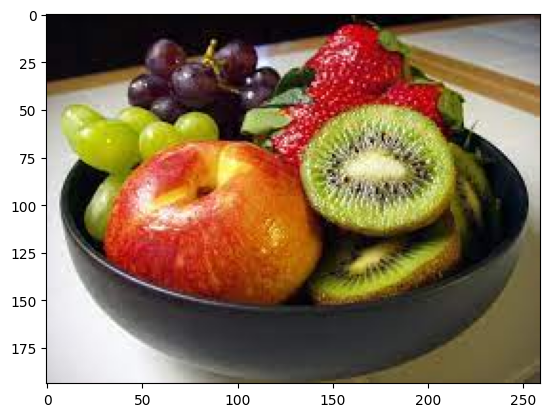

In [42]:
img_bgr2 = cv2.imread('/content/testnotpizza.jpeg')
img_rgb2 = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb2)
plt.show()

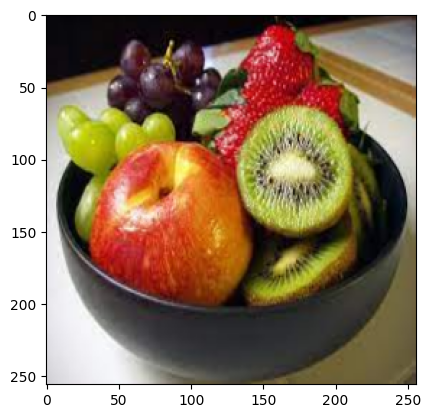

In [43]:
resize2 = tf.image.resize(img_rgb2, (256,256))
plt.imshow(resize2.numpy().astype(int))
plt.show()

In [44]:
yhat2 = model.predict(np.expand_dims(resize2/255, 0))

1/1 [==============================] - 0s 36ms/step


In [45]:
yhat2

array([[0.21916233]], dtype=float32)

In [46]:
if yhat2 > 0.5: 
    print(f'Predicted class is Pizza')
else:
    print(f'Predicted class is NOT Pizza')

Predicted class is NOT Pizza


In [47]:
from tensorflow.keras.models import load_model

In [48]:
model.save(os.path.join('models','pizzaclassifier.h5'))

In [49]:
new_model = load_model('/content/models/pizzaclassifier.h5')

In [50]:
new_model.predict(np.expand_dims(resize1/255, 0))

1/1 [==============================] - 0s 98ms/step


array([[0.99208003]], dtype=float32)